### 导入依赖库

In [1]:
import tensorflow as tf
import numpy as np
from numpy.random import RandomState
from tensorflow.keras.losses import binary_crossentropy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import platform

### 运行环境要求

In [2]:
print("Environment: TensorFlow %s, Python %s" % (tf.__version__, platform.python_version()))

Environment: TensorFlow 1.15.0, Python 3.7.9


### 获取并加工数据集

In [3]:
!wget https://raw.githubusercontent.com/ThomasAtlantis/SJTUNNTA/master/data.txt

data = np.array(list(map(
    lambda _: list(map(float, _)), 
    [line.strip().split() for line in open("data.txt", "r").readlines()]
)))
train_X, train_y = data[:,:2].reshape(-1, 2), data[:, 2].reshape(-1, 1)
print(train_X.shape, train_y.shape)

--2021-04-07 14:40:23--  https://raw.githubusercontent.com/ThomasAtlantis/SJTUNNTA/master/data.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... ^C
(194, 2) (194, 1)


### 训练模型

In [5]:
# Hyper-parameters
EPOCH, learning_rate = 5000, 0.0015
featre_dim, hidden_dim, output_dim = 2, 32, 1

# define and initialize weights and biases
u1 = tf.Variable(tf.random.normal([featre_dim, hidden_dim], seed=1))
v1 = tf.Variable(tf.random.normal([featre_dim, hidden_dim], seed=1))
b1 = tf.Variable(tf.random.normal([hidden_dim], seed=1))

u2 = tf.Variable(tf.random.normal([hidden_dim, output_dim], seed=1))
v2 = tf.Variable(tf.random.normal([hidden_dim, output_dim], seed=1))
b2 = tf.Variable(tf.random.normal([output_dim], seed=1))

# define input placeholder and target placeholder
X = tf.placeholder(tf.float32, shape=(None, featre_dim))
y = tf.placeholder(tf.float32, shape=(None, output_dim))

# define forward propagation process
t = tf.tanh(   tf.matmul(tf.square(X), u1) + tf.matmul(X, v1) + b1)
h = tf.sigmoid(tf.matmul(tf.square(t), u2) + tf.matmul(t, v2) + b2)

# define loss as cross entropy
loss = tf.reduce_mean(binary_crossentropy(y, h))

# use Adam optimizer
train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)

log_train_acc = []
log_train_los = []

# training ...
saver = tf.train.Saver()
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for i in range(EPOCH):
        
        # online learning 
        for _X, _y in zip(train_X, train_y):
            sess.run(train_step, feed_dict={
                X: _X.reshape(1, 2), 
                y: _y.reshape(1, 1)
            })
        
        # log current loss and accuracy
        if i % 50 == 0:
            los, y_hat = sess.run([loss, h], feed_dict={X: train_X, y: train_y})
            acc = np.mean(np.abs(y_hat - train_y) < 0.5)
            print("After {:>5d} training_step(s), los: {:.4f}, acc: {:.4f}".format(i, los, acc))
            log_train_acc.append(acc)
            log_train_los.append(los)

    # save the model
    saver.save(sess, "MLQPModel/model.ckpt")


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
After     0 training_step(s), los: 3.6334, acc: 0.5155
After    50 training_step(s), los: 0.5558, acc: 0.6546
After   100 training_step(s), los: 0.4996, acc: 0.6959
After   150 training_step(s), los: 0.4431, acc: 0.7216
After   200 training_step(s), los: 0.4021, acc: 0.7526
After   250 training_step(s), los: 0.3708, acc: 0.7732
After   300 training_step(s), los: 0.3264, acc: 0.8299
After   350 training_step(s), los: 0.3032, acc: 0.8351
After   400 training_step(s), los: 0.2885, acc: 0.8351
After   450 training_step(s), los: 0.2848, acc: 0.8402
After   500 training_step(s), los: 0.2825, acc: 0.8454
After   550 training_step(s), los: 0.2802, acc: 0.8454
After   600 training_step(s), los: 0.2783, acc: 0.8454
After   650 training_step(s), los: 0.2767, acc: 0.8454
After   700 training_step(s), los: 0.2732, acc: 0.8454
After   750 training_step(s), los: 0.2678, acc: 0.8505
After   800 training_step(

### 分类界面可视化

INFO:tensorflow:Restoring parameters from MLQPModel/model.ckpt


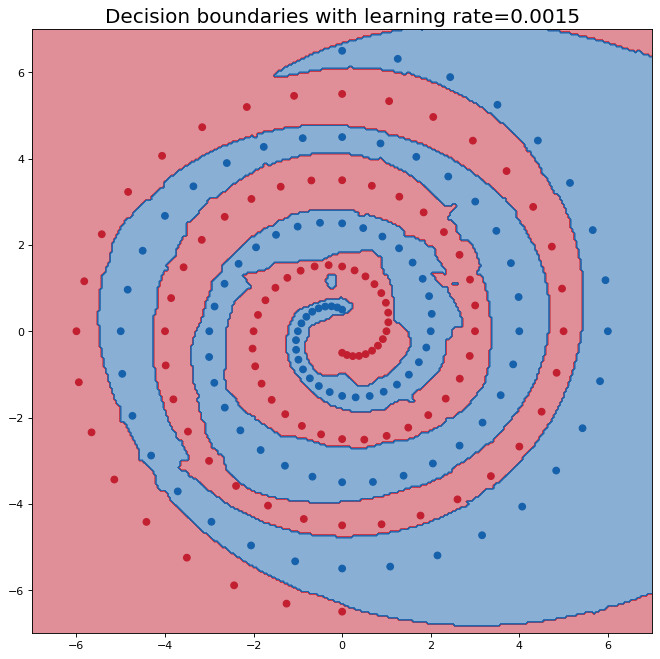

In [6]:
saver = tf.train.Saver()
with tf.Session() as sess:
    
    # restore the model
    saver.restore(sess, "MLQPModel/model.ckpt")
    color_map = colors.ListedColormap(["#c21f30", "#1661ab"])
    plt.figure(figsize=(10, 10), dpi=80)
    plt.title("Decision boundaries with learning rate=%.4f" % learning_rate, fontsize=18)

    # draw the classification boundary
    grid1 = np.linspace(-7, 7, 300)
    grid2 = np.linspace(-7, 7, 300)
    xx, yy = np.meshgrid(grid1, grid2)
    Grid = np.vstack([xx.reshape(-1), yy.reshape(-1)]).T
    y = np.array(sess.run(h, feed_dict={X: Grid}))
    zz = np.argmax(np.hstack([1-y, y]), axis=-1).reshape(xx.shape)
    plt.contourf(xx, yy, zz, cmap=color_map, alpha=0.5)
    
    # draw training samples
    plt.scatter(train_X[:, 0], train_X[:, 1], c=train_y, cmap=color_map)
    plt.show()

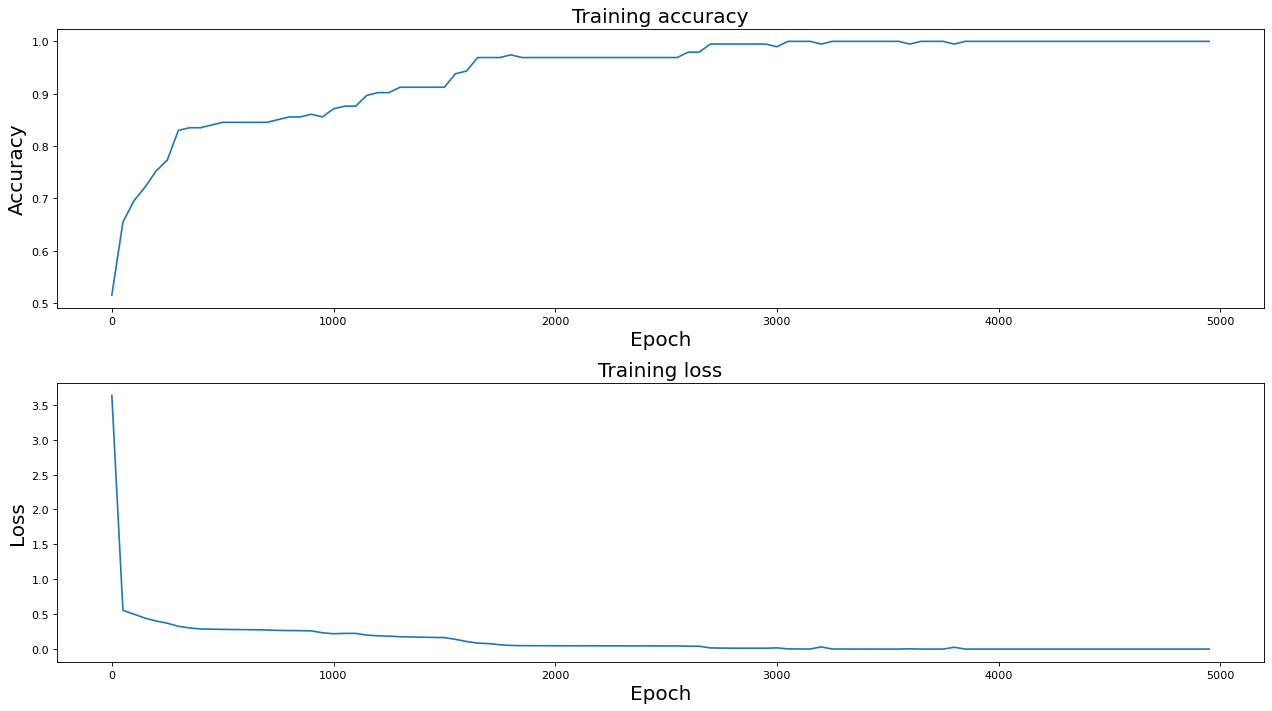

In [9]:
plt.figure(figsize=(16, 9), dpi=80)
x_range = np.arange(len(log_train_acc)) * 50

plt.subplot(211)
plt.title("Training accuracy", fontsize=18)
plt.xlabel("Epoch", fontsize=18)
plt.ylabel("Accuracy", fontsize=18)
plt.plot(x_range, log_train_acc)

plt.subplot(212)
plt.title("Training loss", fontsize=18)
plt.xlabel("Epoch", fontsize=18)
plt.ylabel("Loss", fontsize=18)
plt.plot(x_range, log_train_los)

plt.tight_layout()
plt.show()